## Target Maximization

This section covers budget optimization by maximizing target with the insights from a fitted MMM.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle

from karpiu.planning import TargetMaximizer
from karpiu.planning.calculator import calculate_marginal_cost, generate_cost_report
from karpiu.explainability import Attributor

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [3]:
with open("./resource/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [4]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.05736,0.04121,0.07378,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.05506,0.03968,0.06886,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.20909,0.18660,0.23081,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.07827,0.05903,0.09767,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.10681,0.08683,0.12805,1.00000,0.00000,0.00000,0.10000


In [5]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-31")
optim_channels = mmm.get_spend_cols()

# spend_scaler a fixed constant to reduce over-float of spend
# not that they need to be consistent with the subsequent calculation of
# post optimization metrics
spend_scaler = 1e3

In [6]:
maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channel=optim_channels,
)
optim_spend_df = maximizer.optimize(maxiter=1000, eps=1e-3)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -7332.824654693589
            Iterations: 93
            Function evaluations: 14405
            Gradient evaluations: 92


In [7]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [8]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 490508
Total Budget: 490508


### Budget Allocation

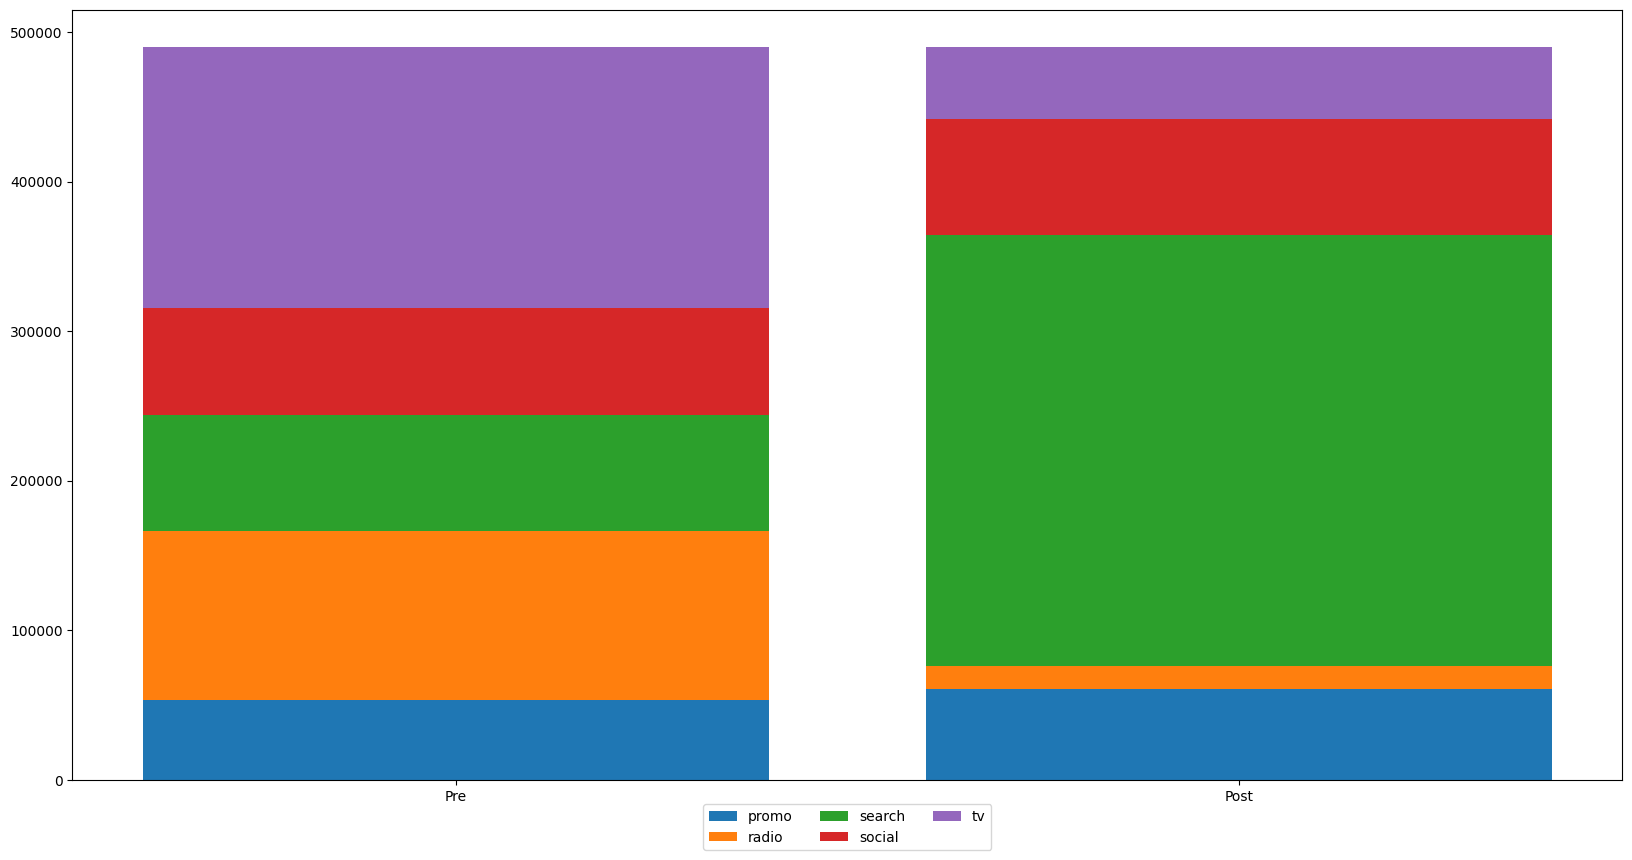

In [9]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
# ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

### Average and Marginal Cost Change

In [10]:
df = mmm.get_raw_df()

In [11]:
df

,date,sales,promo,radio,search,social,tv
0,2019-01-01,784.00000,2003.00000,4779.00000,4603.00000,2123.00000,14120.00000
1,2019-01-02,865.00000,2210.00000,2676.00000,4028.00000,0.00000,7076.00000
2,2019-01-03,803.00000,0.00000,7219.00000,4037.00000,4000.00000,4118.00000
3,2019-01-04,808.00000,0.00000,7826.00000,3722.00000,0.00000,2926.00000
4,2019-01-05,871.00000,1076.00000,7877.00000,4353.00000,1771.00000,10259.00000
...,...,...,...,...,...,...,...
1062,2021-11-28,1434.00000,2143.00000,4028.00000,4762.00000,3858.00000,0.00000
1063,2021-11-29,1479.00000,2599.00000,0.00000,3328.00000,2232.00000,862.00000
1064,2021-11-30,1605.00000,2473.00000,0.00000,3901.00000,2765.00000,14481.00000
1065,2021-12-01,1486.00000,1068.00000,1583.00000,3879.00000,2198.00000,0.00000


In [12]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend
promo,38.86283,39.20615,42.87664,42.53667,53.30000,60.88185
radio,79.55461,40.15379,88.34060,44.06480,112.97900,15.12679
search,21.24898,38.79932,23.17861,42.55658,78.03300,288.39461
social,40.12583,40.19404,43.79484,42.52387,71.64400,77.48012
tv,65.72122,39.81799,71.33880,43.87787,174.55200,48.62464


### Outcome Plot

In [13]:
df = mmm.get_raw_df()
optim_pred = mmm.predict(optim_spend_df)
init_pred = mmm.predict(df)

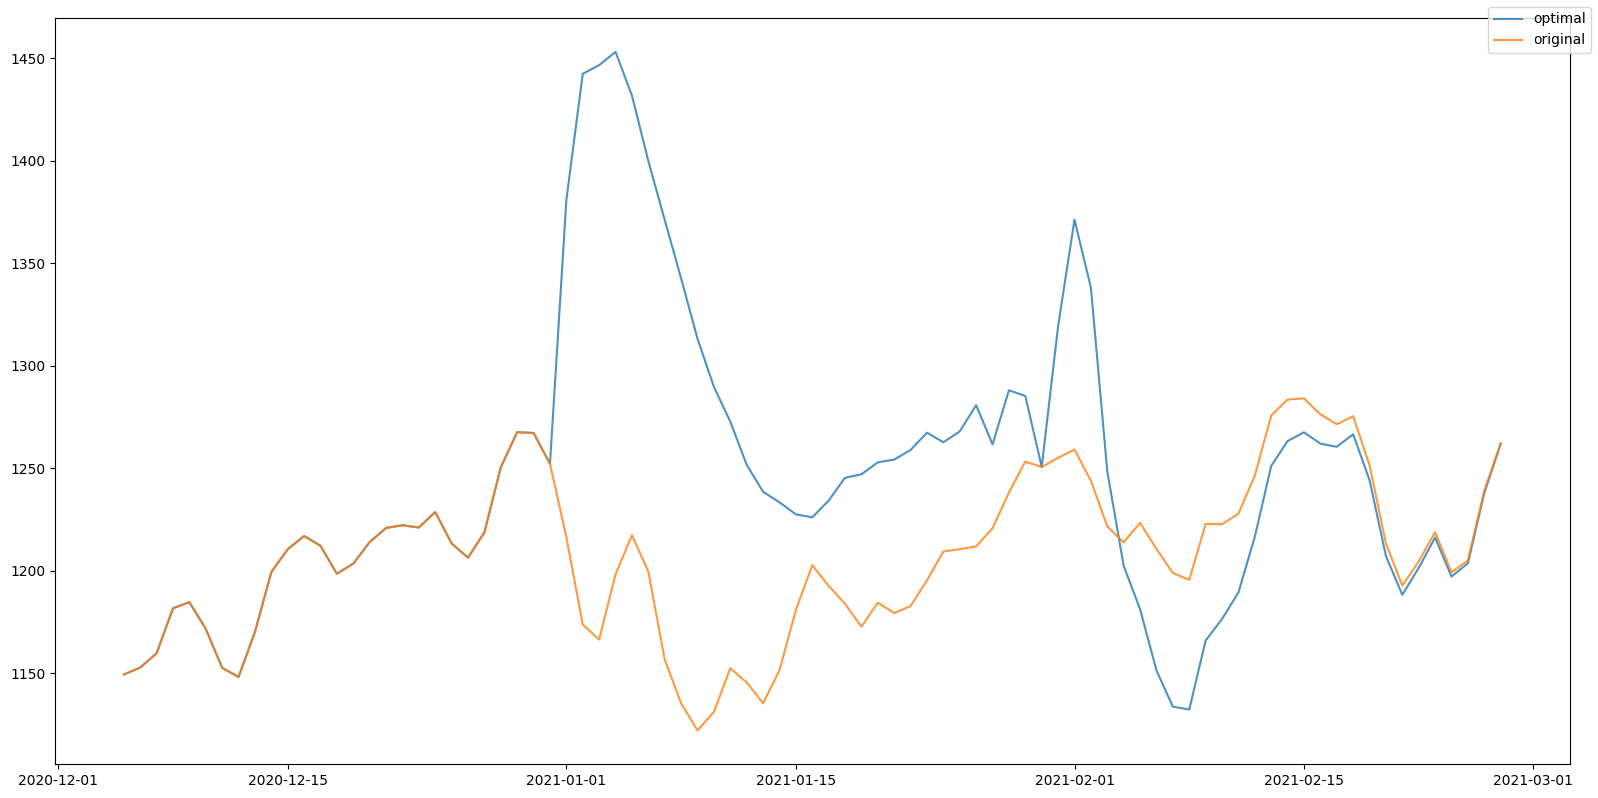

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
measurement_mask = (df["date"] >= maximizer.calc_start) & (
    df["date"] <= maximizer.calc_end
)
ax.plot(
    optim_pred.loc[measurement_mask, "date"].values,
    optim_pred.loc[measurement_mask, "prediction"].values,
    label="optimal",
    alpha=0.8,
)
ax.plot(
    init_pred.loc[measurement_mask, "date"].values,
    init_pred.loc[measurement_mask, "prediction"].values,
    label="original",
    alpha=0.8,
)
fig.legend()
fig.tight_layout();

In [15]:
# check2: total predicted response must be higher than current
total_optim_pred = np.sum(optim_pred.loc[measurement_mask, "prediction"].values)
total_init_pred = np.sum(init_pred.loc[measurement_mask, "prediction"].values)
assert total_optim_pred > total_init_pred